# TRGDW Database

In this notebook, we document and give a high level description of the Household level data we have collected in our database. Accessing this data require an userid and a password. The database is hosted on a SQL server. Connecting to it through an API using for example, python, would require necessary odbc driver. 

Import the general libraries first and connect to the SQL server

In [1]:
import pyodbc
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
import datetime

In [2]:
#- Reading my userid and password from the environment variables
trguid=os.environ['TRGUID']
trgpwd=os.environ['TRGPWD']
#- Now we establish a connection so that we will be able to perform a query using pandas read_sql module
#- in python one can use pyodbc or create an engine using sqlalchemy
driver='/usr/local/lib/libmsodbcsql.17.dylib' #- local odbc drive
server='129.119.63.219'
dbname='TRGDW'
port=1433
cnxnTRG=pyodbc.connect(driver=driver,server=server,database=dbname,uid=trguid,\
                       pwd=trgpwd,port=port)

Check the tables in the database

In [3]:
cursor = cnxnTRG.cursor()
for row in cursor.tables(tableType='TABLE'):
    if row[1]=='dbo': #- avoiding system tables
        print(row[2])

Activity
Activity_20200501
FipsstateMap
HouseHold
HouseHold_20200501
Household2020_clean
Organization
OrgGenre
OrgMap
OrgMapTEST
sysdiagrams
TradeSummary
TRGCompany
TRGCompanyStats
TRGMap
TRGOrgInteg


To avoid redundancy, we have already cleaned and integrated static TRG information. So the only tables of interest are **TRGOrgInteg, Activity_20200501, Household2020_clean, TRGCompany and TRGCompanyStats. NO NEED!!! to check other tables**. We will explore each of these tables below.

In [4]:
def load_data(cnxn,sqlquery):
    """
    cnxn: pyodbc.Connection object
    sqlquery: sql query string
    returns pandas dataframe from the sqlquery. 
    Use only for small databases if running from stanalone node-- to make efficient 
    need distributed architecture for larger databases 
    """
    cursor=cnxn.cursor()
    data=pd.read_sql(sqlquery,cursor.connection)
    return data

For data description we will limit our queries to a few rows. If one expects to extract the full table, it may be slow with the above function. One may increase the data loading efficiency by some form of parallel processing.

### TRGOrgInteg

In [5]:
#- look at the schema
for row in cursor.columns(table='TRGOrgInteg'):
    print(row[3],row[5])

NCARID float
OrgID bigint
ORGName varchar
ADDRESS varchar
CITY varchar
STATE varchar
ZIP float
ZIP9 varchar
STATENO float
County float
FTRACT float
CensusBlock float
CNTYNM varchar
CBSA float
LATITUDE float
LONGITUDE float
NetworkCode varchar
NetworkName varchar
Active bigint
InactiveDate float
AnnualRevenue float
AnnualRevenueYear float
PostalCode varchar
TRG_Genre varchar
sec_no float


Data Description: 
![](TRGInteg_datades.png)

In [6]:
sqlquery='select * from TRGOrgInteg'
trgIntDF=load_data(cnxnTRG,sqlquery)
trgIntDF.head()

,NCARID,OrgID,ORGName,ADDRESS,CITY,STATE,ZIP,ZIP9,STATENO,County,...,LONGITUDE,NetworkCode,NetworkName,Active,InactiveDate,AnnualRevenue,AnnualRevenueYear,PostalCode,TRG_Genre,sec_no
0,154202.0,1516,Barter Theatre,PO Box 867,ABINGDON,VA,24212.0,24212-0867,51.0,51191.0,...,-81.974386,None,None,0,201807.0,8392321.0,2016.0,24210-3202,Education - Performing Arts,11.0
1,150159.0,186,WaterTower Theatre,15650 Addison Rd,ADDISON,TX,75001.0,75001-3285,48.0,48113.0,...,-96.829781,CNNT,TRG Community: North Texas,1,NaN,1418207.0,2018.0,75001-3285,Theater,11.0
2,162722.0,851,Front Porch Theatricals,112 Sewickley Ridge Cir,ALEPPO TWP,PA,15143.0,15143-8978,42.0,42003.0,...,-80.147076,GPAC,Greater Pittsburgh Arts Counc,0,201711.0,145000.0,2016.0,15143-8978,Theater,8.0
3,146464.0,1083,Baum School of Art,510 W Linden St,ALLENTOWN,PA,18101.0,18101-1416,42.0,42077.0,...,-75.469017,CNPH,TRG Community: Philadelphia,0,201709.0,0.0,0.0,18101-1416,Museum - Visual Art/Gallery,1.0
4,146462.0,1084,Lehigh Valley Arts Council,840 Hamilton St,ALLENTOWN,PA,18101.0,18101-2455,42.0,42077.0,...,-75.474660,CNPH,TRG Community: Philadelphia,1,NaN,253347.0,2017.0,18101-2456,Community/Cultural Center,3.0


Text(0.5, 1.0, 'Distribution of TRG Orgs by Active/Inactive status')

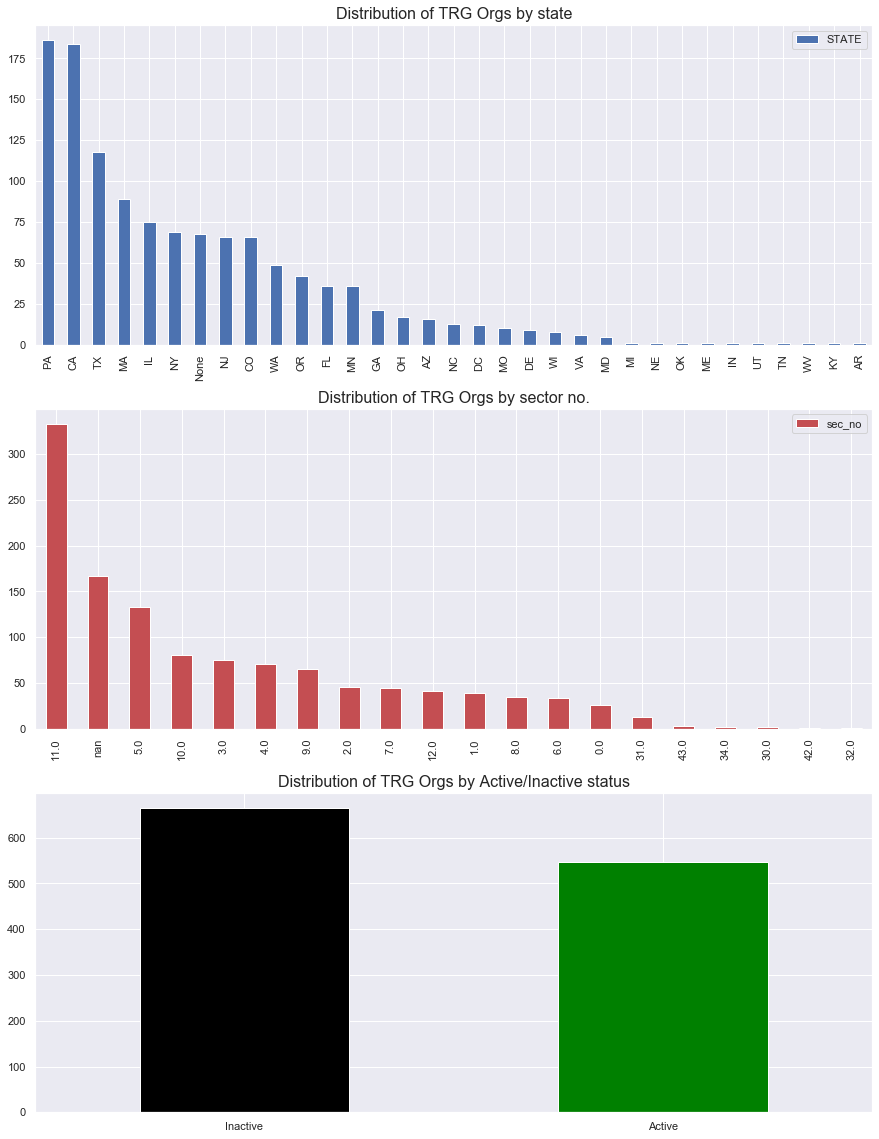

In [7]:
#- Categorical Distributions
fig=plt.figure(figsize=(15,20))
ax1=plt.subplot(311)
trgIntDF['STATE'].astype(str).value_counts().plot(kind='bar')
ax1.legend()
plt.title('Distribution of TRG Orgs by state',fontsize=16)
ax2=plt.subplot(312)
trgIntDF['sec_no'].astype(str).value_counts().plot(kind='bar',color='r')
ax2.legend()
plt.title('Distribution of TRG Orgs by sector no.',fontsize=16)
ax3=plt.subplot(313)
trgIntDF['Active'].astype(str).value_counts().plot.bar(color=['Black','Green'])
#trgIntDF['Active'].astype(str).value_counts().plot(kind='bar',color=['Black','Green'],label='Inactive')
ax3.set_xticklabels(['Inactive','Active'],rotation=0)
plt.title('Distribution of TRG Orgs by Active/Inactive status',fontsize=16)

### Household data

In [8]:
#- look at the schema
for row in cursor.columns(table='Household2020_clean'):
    if row[1]=='dbo':
        print(row[3],row[5])

HouseholdID bigint
CountyCode varchar
FTract varchar
BlockGroup varchar
City varchar
State varchar
PostalCode varchar
Fipsstatecode float


Household Static Data description: 
![](HH_static_data.png)

Household Data Distribution full set
![](TRG_HH_datadis.png)

In [9]:
sqlquery='select top 100 * from Household2020_clean'
hshldDF=load_data(cnxnTRG,sqlquery)
hshldDF.head()

,HouseholdID,CountyCode,FTract,BlockGroup,City,State,PostalCode,Fipsstatecode
0,19872353,42043,42043022502,420430225021,Harrisburg,PA,17112,42.0
1,19971394,42007,42007600700,420076007001,Beaver Falls,PA,15010,42.0
2,20709578,42101,42101008701,421010087012,Philadelphia,PA,19104,42.0
3,21338944,36061,36061015200,360610152002,New York,NY,10128,36.0
4,22481676,12105,12105012503,121050125031,Kissimmee,FL,34759,12.0


### Activity_20200501

In [10]:
#- look at the schema
for row in cursor.columns(table='Activity_20200501'):
    if row[1]=='dbo':
        print(row[3],row[5])

OrgID int
HouseholdID int
SegmentYear smallint
SegmentTypeCode varchar
SegmentDesc varchar
TransactionAmount money
TransactionQty int
OrderDate datetime
EventDate datetime


Household Activity data description: 
![](HH_activity_datades.png)

In [11]:
sqlquery='select top 100 * from Activity_20200501'
ActDF=load_data(cnxnTRG,sqlquery)
ActDF.head()

,OrgID,HouseholdID,SegmentYear,SegmentTypeCode,SegmentDesc,TransactionAmount,TransactionQty,OrderDate,EventDate
0,593,16340093,2011,GRP,MOLLY EPSTEIN,None,None,None,None
1,593,15542333,2011,GRP,MOLLY EPSTEIN,None,None,None,None
2,593,15537361,2011,GRP,MOLLY EPSTEIN,None,None,None,None
3,593,15222737,2011,GRP,MOLLY EPSTEIN,None,None,None,None
4,593,15320003,2011,GRP,MOLLY EPSTEIN,None,None,None,None


In [12]:
#Checking where Transaction information is available
sqlquery='select top 100 * from Activity_20200501 where TransactionQty>0'
ActDF=load_data(cnxnTRG,sqlquery)
ActDF.head()

,OrgID,HouseholdID,SegmentYear,SegmentTypeCode,SegmentDesc,TransactionAmount,TransactionQty,OrderDate,EventDate
0,280,591215,2013,STB,Bethany,75.0,1,2013-01-30 11:51:00,2013-02-17 14:30:00
1,280,7688452,2014,STB,Row After Row,60.0,3,2014-01-21 09:13:00,2014-02-09 14:30:00
2,280,14598194,2013,STB,Bethany,45.0,2,2013-01-27 20:19:00,2013-02-02 14:30:00
3,280,694624,2013,STB,Jackie,45.0,2,2013-02-19 21:25:00,2013-03-17 14:30:00
4,280,7614365,2013,STB,Collapse,40.0,2,2013-01-31 15:11:00,2013-04-27 19:30:00


Transaction Distribution by year for the full sample:
![](HH_transactions.png)

Transaction distribution by segment type:
![](transaction_segmentcode_activity.png)

### TRGCompany

In [13]:
#- look at the schema
n=0
for row in cursor.columns(table='TRGCompany'):
    if n<=20:  #- only looking at the first 20 fields. Total 411
        if row[1]=='dbo':
            print(row[3],row[5])
    n+=1

OrgID bigint
year bigint
CNTART float
MKTADV float
ARTSATCD float
FRATNDTO float
PDATND float
ALLATTTO float
BOARDCD float
TRUSTNCD float
ENDTOTCD float
FTEMPS float
FTSEAS float
FTVOLS float
DEVSATCD float
GASAT float
HITIX float
LOTIX float
DMAILN float
MKTTOT float
MKTSAT float


TRGCompany Table consists of 411 variables with OrgID, year and the the remaining 409 numeric variables for the TRG organizations spanning from 2008 through 2019. The description of the numeric fields are given in the TRGCompanyStats table. But let's see some description below as well.

In [14]:
#Checking where Transaction information is available
sqlquery='select * from TRGCompany'
TRGcompDF=load_data(cnxnTRG,sqlquery)
TRGcompDF.head()

,OrgID,year,CNTART,MKTADV,ARTSATCD,FRATNDTO,PDATND,ALLATTTO,BOARDCD,TRUSTNCD,...,GABENCD,PRGBENCD,UWEBVIS,ArtsActivity,ArtsProviders,GrantActivity,Hospitality,Substitute,SocioEcon,TOTPOP
0,1012,2008,36598.0,7026.0,NaN,100.0,5003.0,5103.0,10.0,8.0,...,10268.0,21800.0,0.0,0.233247,0.310376,-0.027368,0.187422,-0.147217,-0.093418,11406.837973
1,1012,2009,57887.0,8755.0,NaN,300.0,3925.0,4225.0,10.0,9.0,...,4325.0,25390.0,0.0,0.524995,0.191257,-0.017818,0.327811,-0.200109,-0.096941,11406.837973
2,1012,2010,37799.0,2219.0,NaN,0.0,105260.0,105260.0,10.0,7.0,...,1662.0,22111.0,0.0,0.509109,0.221737,0.444290,0.205557,-0.152727,0.383591,11485.493201
3,1012,2011,0.0,400.0,NaN,0.0,120545.0,120545.0,9.0,9.0,...,2088.0,26273.0,0.0,0.518762,0.341954,-0.444695,0.204866,-0.135336,0.431744,11553.009420
4,1012,2012,33819.0,713.0,76718.0,491.0,0.0,4100.0,8.0,8.0,...,2983.0,24379.0,0.0,0.497554,0.184335,-0.444695,0.177981,-0.245605,0.528201,11590.029118


In [15]:
#- For display, let's take a subset and look at some correlation
selected_fields=['ArtsActivity', 'ArtsProviders',
       'GrantActivity', 'Hospitality', 'Substitute', 'SocioEcon',
       'TOTPOP']
TRGcomp_subset=TRGcompDF[selected_fields]
TRGcomp_subset.describe()

,ArtsActivity,ArtsProviders,GrantActivity,Hospitality,Substitute,SocioEcon,TOTPOP
count,13246.000000,13246.000000,13246.000000,13246.000000,13246.000000,13246.000000,1.324600e+04
mean,0.974061,2.271096,1.723004,1.094885,1.448059,1.096317,2.470085e+05
std,0.381326,1.519767,2.821947,0.798728,1.603717,0.900768,2.000732e+05
min,-1.655881,-1.041982,-0.444695,-1.328030,-0.879976,-1.422394,1.538331e+03
25%,0.791436,1.200293,0.351602,0.504058,0.376510,0.420591,1.273388e+05
50%,0.994557,2.009976,1.047828,1.047564,1.275327,1.082471,1.902962e+05
75%,1.207564,2.867896,1.939133,1.691370,2.495204,1.760716,3.074388e+05
max,1.786953,6.376923,25.179070,3.550326,9.360109,3.935416,1.051378e+06


One can look at the correlations in a pair plot

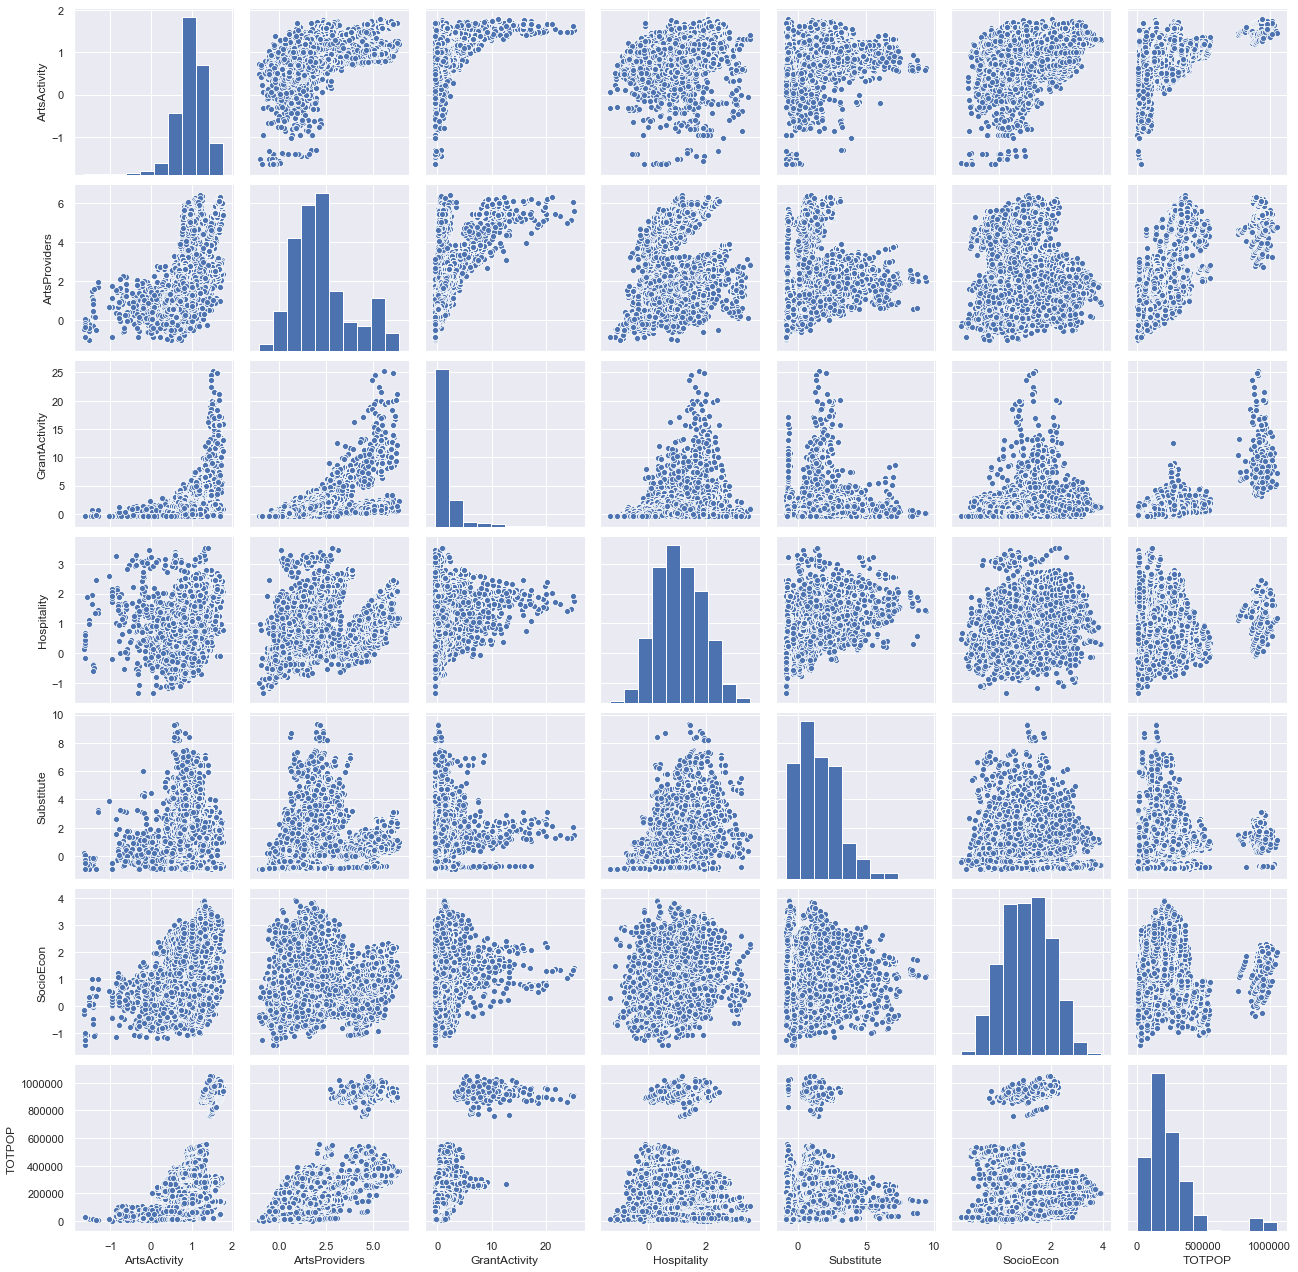

In [16]:
sns.pairplot(TRGcomp_subset)

Or one can also create a correlation matrix/see the overall correlation coefficients across the variables

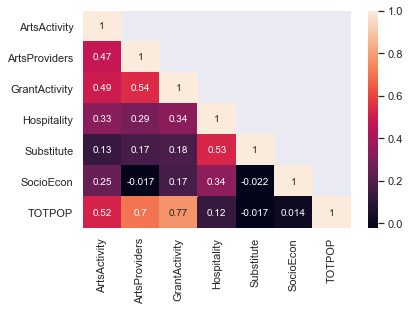

In [17]:
corrMatrix=TRGcomp_subset.corr()
corrMatrix=corrMatrix.where(np.tril(np.ones(corrMatrix.shape)).astype(np.bool))
#mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
sns.heatmap(corrMatrix,annot=True)
plt.show()

The tables above can be joined by the ORGID/householdID. In this framework the join can be performed in the SQL query itself, or at the dataframe level. For larger tables, it is more efficient to perform the join operations in the SQL query itself


In [18]:
TRGcomp_subset

,ArtsActivity,ArtsProviders,GrantActivity,Hospitality,Substitute,SocioEcon,TOTPOP
0,0.233247,0.310376,-0.027368,0.187422,-0.147217,-0.093418,11406.837973
1,0.524995,0.191257,-0.017818,0.327811,-0.200109,-0.096941,11406.837973
2,0.509109,0.221737,0.444290,0.205557,-0.152727,0.383591,11485.493201
3,0.518762,0.341954,-0.444695,0.204866,-0.135336,0.431744,11553.009420
4,0.497554,0.184335,-0.444695,0.177981,-0.245605,0.528201,11590.029118
...,...,...,...,...,...,...,...
13241,0.487631,-0.085477,-0.444695,-0.256045,0.176473,0.371721,71287.656183
13242,0.521980,-0.112383,-0.444695,-0.257550,0.224276,0.370371,71744.895173
13243,0.378935,-0.198211,-0.444695,-0.220531,0.326361,0.399870,72133.488822
13244,0.559540,-0.506832,-0.443646,-0.855271,-0.818810,0.510956,73720.210891


# CensusDB

We also have cleaned and integrated Census TRACT and Block Group level data that can be merged with the TRG data for TRACT and Block group level analyses. For this, the database is CensusDB

In [19]:
#- We create a new connection instance
censusdb='CensusDB'
cnxnCNS=pyodbc.connect(driver=driver,server=server,database=censusdb,uid=trguid,pwd=trgpwd,port=port)

In [20]:
#- checking the tables
cursor = cnxnCNS.cursor()
for row in cursor.tables(tableType='TABLE'):
    if row[1]=='dbo': #- avoiding system tables
        print(row[2])

BlkGrpcommute
BlkGrpecon
BlkGrpeduc
BlkGrplatin
BlkGrpmedhhinc
BlkGrppoverty
BlkGrprace
Tractdemo
Tractecon
Tracteduc


The table names indicate the kinds of data in each table. The BlkGrp data span 2013-2019 and tract level data span from 2008-2019. Lets see some of the data


### BlkGrpcommute

In [21]:
sqlquery='select * from BlkGrpcommute'
BlkComDF=load_data(cnxnCNS,sqlquery)
BlkComDF.head()

,BlkGrp,YEAR,CommuteN,AvgCommute,STATE
0,270332701002,2018,401,13.264339,Minnesota
1,270332701003,2018,503,16.127237,Minnesota
2,270332702002,2018,307,22.446254,Minnesota
3,270332702003,2018,208,22.817308,Minnesota
4,270332703002,2018,412,16.371359,Minnesota


So that shows the average commute time by year for each BlkGrp. 

### BlkGrpecon

In [22]:
sqlquery='select * from BlkGrpecon'
BlkeconDF=load_data(cnxnCNS,sqlquery)
BlkeconDF.head()

,BlkGrp,YEAR,TotHse,LT50p,GT100p,GT125p,GT150p,GT200p,STATE
0,270332701002,2018,435,0.450575,0.055172,0.022989,0.018391,0.002299,Minnesota
1,270332701003,2018,539,0.551020,0.072356,0.040816,0.040816,0.024119,Minnesota
2,270332702002,2018,288,0.423611,0.197917,0.093750,0.052083,0.038194,Minnesota
3,270332702003,2018,218,0.399083,0.142202,0.055046,0.032110,0.027523,Minnesota
4,270332703002,2018,322,0.285714,0.298137,0.121118,0.077640,0.012422,Minnesota


This shows the economy data for each BlkGrp by year. And so on is the data for education, ethnicity, race and poverty. The tract level data also include the same information for the tract levels.  

# Combining aka merging aka joining data sets

We show two ways to merge the data sets and pick Tract level census data to do so as an example

In [23]:
#- Tract level Census data
Tracttables=['Tractdemo','Tractecon','Tracteduc']
for tab in Tracttables:
    print("Table schema: ", tab)
    for row in cursor.columns(table=tab):
        print(row[3],row[5])  

Table schema:  Tractdemo
TRACT bigint
TOTPOP bigint
WHIT bigint
BLCK bigint
AMIND bigint
ASIA bigint
HAWA bigint
LATIN bigint
YEAR bigint
STATE varchar
Table schema:  Tractecon
TRACT bigint
POP16 bigint
LT50P varchar
GT100P varchar
GT150P varchar
GT200P varchar
PovPerc varchar
YEAR bigint
STATE varchar
Table schema:  Tracteduc
TRACT bigint
POP25 bigint
BACHP varchar
GRADP varchar
BachPlusP varchar
YEAR bigint
STATE varchar


As we see, we have TRACT, YEAR, STATE in all Tract tables, so we will use these to join the tables.

#### Using SQL join query -- fast

In [24]:
sqlquery='select a.TRACT,a.YEAR,a.STATE,TOTPOP,WHIT,BLCK,AMIND,ASIA,HAWA,LATIN,\
          POP16,LT50P,GT100P,GT150P,GT200P,PovPerc,\
          POP25,BACHP,GRADP,BachPlusP from Tractecon a \
          full outer join Tracteduc b \
          on a.TRACT=b.TRACT and a.YEAR=b.YEAR and a.STATE=b.STATE \
          full outer join Tractdemo c \
          on a.TRACT=c.TRACT and a.YEAR=c.YEAR and a.STATE=c.STATE'


In [25]:
#%%timeit
#TRACT_dataDF=load_data(cnxnCNS,sqlquery)
#==> 2min 16s ± 12.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [26]:
t1 = datetime.datetime.now()
TRACT_dataDF=load_data(cnxnCNS,sqlquery)
t2 = datetime.datetime.now()
print("Time taken to execute the query and load to DF  [Seconds] ", (t2-t1).seconds)

Time taken to execute the query and load to DF  [Seconds]  148


In [27]:
print(TRACT_dataDF.shape)
TRACT_dataDF.head()

(814013, 20)


,TRACT,YEAR,STATE,TOTPOP,WHIT,BLCK,AMIND,ASIA,HAWA,LATIN,POP16,LT50P,GT100P,GT150P,GT200P,PovPerc,POP25,BACHP,GRADP,BachPlusP
0,1001020100,2009,Alabama,1856.0,1547.0,316.0,73.0,0.0,0.0,15.0,1392,14.699999999999999,21.5,2.0,7.0,10.5,1253.0,12.800000000000001,11.0,23.800000000000001
1,1001020100,2012,Alabama,1812.0,1600.0,230.0,54.0,3.0,0.0,0.0,1412,13.6,19.6,5.2,3.2,9.2,1206.0,12.9,10.9,23.8
2,1001020100,2014,Alabama,1900.0,1742.0,156.0,25.0,31.0,0.0,14.0,1492,12.8,22,6.5,3.1,10,1209.0,14.3,12.3,26.6
3,1001020100,2015,Alabama,1948.0,1780.0,157.0,29.0,25.0,17.0,17.0,1554,8.5,19.5,4.5,1,8.1,1243.0,13.4,14.2,27.5
4,1001020100,2017,Alabama,1845.0,1727.0,134.0,31.0,31.0,13.0,44.0,1483,5.7000000000000002,20.800000000000001,10.800000000000001,1.6000000000000001,10.699999999999999,1259.0,20.699999999999999,17.100000000000001,37.799999999999997


#### Using individual dataframe -- slow

In [28]:
#%%timeit
#squery='select * from Tractecon'
#testDF=load_data(cnxnCNS,squery)

In [29]:
t3 = datetime.datetime.now()
squery1='select * from Tractecon'
squery2='select * from Tracteduc'
squery3='select * from Tractdemo'

print("Reading Tract economy data")
econDF=load_data(cnxnCNS,squery1)
print("Reading Tract education data")
educDF=load_data(cnxnCNS,squery2)
print("Reading Tract demographics data")
demoDF=load_data(cnxnCNS,squery3)

tract_mergeDF1=econDF.merge(educDF,on=['TRACT','YEAR','STATE'],how='outer')
tract_mergeDF2=tract_mergeDF1.merge(demoDF,on=['TRACT','YEAR','STATE'],how='outer')

t4 = datetime.datetime.now()
print("Time taken on full data queries and DF merge [Seconds] ", (t4-t3).seconds)


Reading Tract economy data
Reading Tract education data
Reading Tract demographics data
Time taken on full data queries and DF merge [Seconds]  162


In [30]:
print(tract_mergeDF2.shape)
tract_mergeDF2.head()

(814013, 20)


,TRACT,POP16,LT50P,GT100P,GT150P,GT200P,PovPerc,YEAR,STATE,POP25,BACHP,GRADP,BachPlusP,TOTPOP,WHIT,BLCK,AMIND,ASIA,HAWA,LATIN
0,1001020100,1396,14.699999999999999,18.021468290000001,1.8803097219999998,5.9569049620000003,9.0918167759999999,2008,Alabama,1234.0,11.050633270000001,9.7291630170000012,20.750948409999999,1852.0,1552.0,291.0,67.0,0.0,0.0,15.0
1,1001020200,1516,17.300000000000001,13.474851320000001,0.29874091199999997,1.5685701780000001,12.96785751,2008,Alabama,1254.0,14.157830929999999,7.590958616,21.930149579999998,2045.0,855.0,1128.0,0.0,22.0,0.0,6.0
2,1001020300,2549,21.800000000000001,11.4979377,3.6633025469999998,0.45844473399999996,6.914585679,2008,Alabama,2175.0,11.32799376,1.362691852,12.643148160000001,3443.0,2891.0,539.0,0.0,31.0,0.0,39.0
3,1001020400,3638,15.6,13.65610053,3.4820126600000001,1.3284576959999999,5.4389412429999995,2008,Alabama,3120.0,13.756875389999999,6.8137658339999998,20.713600530000001,4639.0,4486.0,85.0,22.0,14.0,0.0,128.0
4,1001020500,6948,12.5,18.500227150000001,5.3617976160000005,0.97059919500000003,5.3786507590000001,2008,Alabama,5619.0,21.31521575,9.9805559810000002,31.834601150000001,9339.0,8067.0,1131.0,88.0,146.0,0.0,471.0
